In [2]:
import numpy as np
import requests
import pandas as pd
import json
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_style("whitegrid")
sns.set_context("poster")
#read in df
ppdf=pd.read_pickle('clean_data.pkl')

The goal of this data story is to find an interesting thing to analyze in future statistical analysis. The first major question we have to ask is what is normal variability in gambling lines? to do this we should exclude bad weather examples. This should show us what results are 'normal'

In [3]:
#make sure dtypes are right
ppdf=ppdf.astype({'precipitation':'float','schedule_week':'float'})
#this will be useful when we have df grouped
ppdf['true']=True
#lets take a quick look
ppdf.loc[:4455,'spread_favorite':]

,spread_favorite,results,results-spread,favorite_cover,over_under_line,total,over_diff,over_cover,weather_temperature,weather_wind_mph,stadium,coordinates,zipcode,weather_detail,precipitation,true
4450,-2.5,3.0,5.5,False,44.0,23.0,21.0,False,68.0,11.0,Ralph Wilson Stadium,"(42.7738, -78.787)",14127,NaN,0.49,True
4451,-3.5,-27.0,-23.5,True,46.0,41.0,5.0,False,66.0,16.0,Soldier Field,"(41.8623, -87.6167)",60605,NaN,0.00,True
4452,-5.5,-7.0,-1.5,True,47.0,35.0,12.0,False,68.0,10.0,Cinergy Field,"(39.095, -84.516)",45202,NaN,2.48,True
4453,-4.0,7.0,11.0,False,46.0,35.0,11.0,False,62.0,9.0,Mile High Stadium,"(39.7438, -105.02)",80204,NaN,0.00,True
4454,-4.0,-14.0,-10.0,True,43.0,48.0,-5.0,True,72.0,0.0,Pontiac Silverdome,"(42.34, -83.0455)",48226,DOME,0.00,True
4455,-3.0,-27.0,-24.0,True,43.0,41.0,2.0,False,62.0,15.0,Lambeau Field,"(44.5013, -88.0622)",54304,NaN,1.32,True


In [4]:

#Create two dataframes so we can attempt to control the effects of weather
bw=ppdf[(ppdf.weather_wind_mph>=14.9) | (ppdf.weather_temperature<=32)  | (ppdf.precipitation>=1.5)]
nw=ppdf[(ppdf.weather_wind_mph<14.9) & (ppdf.weather_temperature>32)& (ppdf.precipitation<1.5)]


In [5]:
#create a bad weather column. Coul be useful later on
ppdf['bw']=(ppdf.weather_wind_mph>=14.9) | (ppdf.weather_temperature<=32)  | (ppdf.precipitation>=1.5)



In [6]:
#Find covers by year and cover percentage for each year
grp=nw.groupby('schedule_season')
NW_covs_by_yr=grp.favorite_cover.sum()
percentage_NW_covs=NW_covs_by_yr/grp.true.sum()
NW_avg_result_sp=grp['results-spread'].mean()


In [7]:
#Find covers by year and cover percentage for each year
grp=nw.groupby('schedule_season')
NW_over_covs_by_yr=grp.over_cover.sum()
percentage_NW_over_covs=NW_over_covs_by_yr/grp.true.sum()
NW_avg_result_ov=grp['over_diff'].mean()

In [8]:
#Find covers by year and cover percentage for each year
grp=bw.groupby('schedule_season')
BW_covs_by_yr=grp.favorite_cover.sum()
percentage_BW_covs=BW_covs_by_yr/grp.true.sum()
BW_avg_result_sp=grp['results-spread'].mean()

In [9]:
#Find covers by year and cover percentage for each year
grp=bw.groupby('schedule_season')
BW_over_covs_by_yr=grp.over_cover.sum()
percentage_BW_over_covs=BW_over_covs_by_yr/grp.true.sum()
BW_avg_result_ov=grp['over_diff'].mean()

('Mean:', 0.12088986922050401, 'STD:', 1.00497353102711)


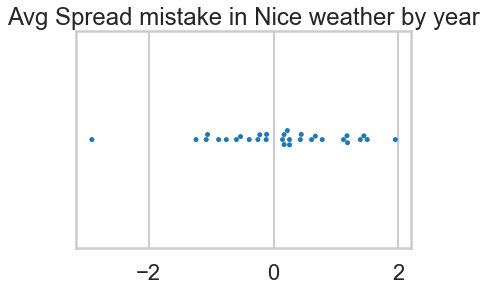

In [10]:
#Plot the average difference between spread and result in nice weather by year
_=sns.swarmplot( NW_avg_result_sp.values)
_=plt.title('Avg Spread mistake in Nice weather by year')
print('Mean:',NW_avg_result_sp.mean(), "STD:",NW_avg_result_sp.std())
plt.show()

('Mean:', -0.88727828566686, 'STD:', 0.8887786140798668)


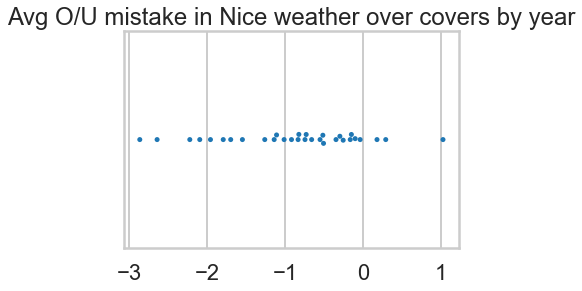

In [11]:
#Plot the average difference between the O/U and result in nice weather by year
_=sns.swarmplot( NW_avg_result_ov.values)
_=plt.title('Avg O/U mistake in Nice weather over covers by year')
print('Mean:',NW_avg_result_ov.mean(), "STD:",NW_avg_result_ov.std())
plt.show()

('Mean:', -0.4853833154202606, 'STD:', 2.9455962397640727)


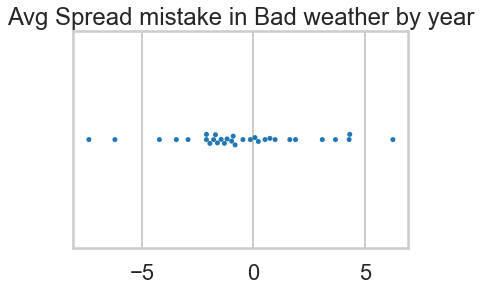

In [12]:
#Plot the average difference between spread and result in bad weather by year
_=sns.swarmplot( BW_avg_result_sp.values)
_=plt.title('Avg Spread mistake in Bad weather by year')
print('Mean:',BW_avg_result_sp.mean(), "STD:",BW_avg_result_sp.std())
plt.show()

('Mean:', 0.43446701006177346, 'STD:', 2.4953274073935496)


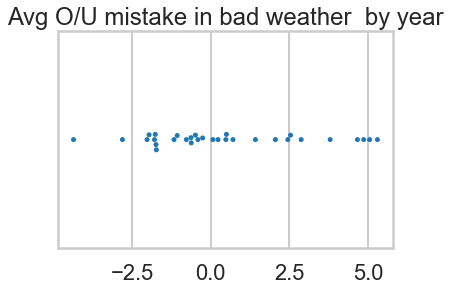

In [13]:
#Plot the average difference between O/U and result in bad weather by year
_=sns.swarmplot( BW_avg_result_ov.values)
_=plt.title('Avg O/U mistake in bad weather  by year')
print('Mean:',BW_avg_result_ov.mean(), "STD:",BW_avg_result_ov.std())
plt.show()

At first look it appears bad weather increases the variablitlity of the gambling lines as seen in there standard deviations. While this insight is interesting, it is questionable as to weather the effect hampering the ability to produce accurate lines because the means to not appear to be far away from zero, whether or not bad weather is involved. Let's take the means and stds for different times in the season to see if some of the weather effect can be attributed to time of the year. Using aboslute value will help us get a better idea of the comparitive accuracy of line setters in good and bad weather.

In [14]:

nw_early=nw[nw['schedule_week']<=6]
nw_mid=nw[(nw['schedule_week']>6) &(nw['schedule_week']<13)]
nw_late=nw[(nw['schedule_week']>=14)]
print('Means:', nw_early['results-spread'].abs().mean(), nw_mid['results-spread'].abs().mean(), nw_late['results-spread'].abs().mean())
print('std:', nw_early['results-spread'].abs().std(), nw_mid['results-spread'].abs().std(), nw_late['results-spread'].abs().std())

('Means:', 10.346540880503145, 10.192966219342896, 10.6290212183436)
('std:', 8.385813512877675, 8.283532668251388, 8.332369193098529)


In [15]:
bw_early=bw[bw['schedule_week']<=6]
bw_mid=bw[(bw['schedule_week']>6)&(bw['schedule_week']<=13)]
bw_late=bw[(bw['schedule_week']>13)]
print('Means:',bw_early['results-spread'].abs().mean(), bw_mid['results-spread'].abs().mean(), bw_late['results-spread'].abs().mean())
print('std:', bw_early['results-spread'].abs().std(), bw_mid['results-spread'].abs().std(), bw_late['results-spread'].abs().std())

('Means:', 11.4, 9.444162436548224, 10.738461538461538)
('std:', 9.520550430681235, 7.632922459736258, 8.492271288455951)


In [16]:
nw_early=nw[nw['schedule_week']<=6]
nw_mid=nw[(nw['schedule_week']>6) &(nw['schedule_week']<13)]
nw_late=nw[(nw['schedule_week']>=14)]
print('Means:', nw['over_diff'].abs().mean(), nw_mid['over_diff'].abs().mean(), nw_late['over_diff'].abs().mean())
print('std:', nw['over_diff'].abs().std(), nw_mid['over_diff'].abs().std(), nw_late['over_diff'].abs().std())

('Means:', 10.705073829720389, 10.679546506247108, 10.858247775496235)
('std:', 8.27045438467765, 8.335731209333, 8.320306612925139)


In [17]:
bw_early=bw[bw['schedule_week']<=6]
bw_mid=bw[(bw['schedule_week']>6)&(bw['schedule_week']<=13)]
bw_late=bw[(bw['schedule_week']>13)]
print(bw_early['over_diff'].abs().mean(), bw_mid['over_diff'].abs().mean(), bw_late['over_diff'].abs().mean())
print('std:', bw_early['over_diff'].abs().std(), bw_mid['over_diff'].abs().std(), bw_late['over_diff'].abs().std())

(10.71875, 10.908629441624365, 11.31868131868132)
('std:', 8.197193778913404, 7.928787800123386, 8.782904300337066)


From this simple analysis, it looks like the Over/Under line is more influenced by weather than the spread, especially as the season goes on. Lets try and dive deeper into that by grouping the data by weeks of the season. Quick note, while their are only 17 weeks in the football season, I have coded playoff games to be numbers, so 18 is the wildcard round, 19 is the divisional, 20 is the confeence title game and 21 is the superbowl. I do not think that this data has to be seperated from the rest because I believe the relationship between the gambling lines and the weather are no different then in the regular season.

Text(0.5,0,'Schedule Week')

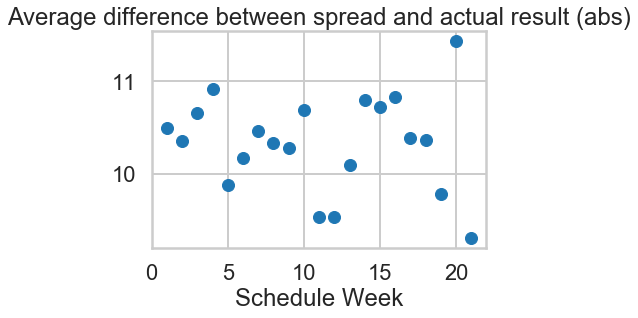

In [18]:
ppdf['over_diffabs']=ppdf.over_diff.abs()
ppdf['resultmSpreadabs']=ppdf['results-spread'].abs()
grp=ppdf.groupby('schedule_week')
plt.plot( grp['resultmSpreadabs'].mean(), linestyle='none', marker='o')
plt.title('Average difference between spread and actual result (abs)')
plt.xlabel('Schedule Week')

Text(0.5,0,'Schedule Week')

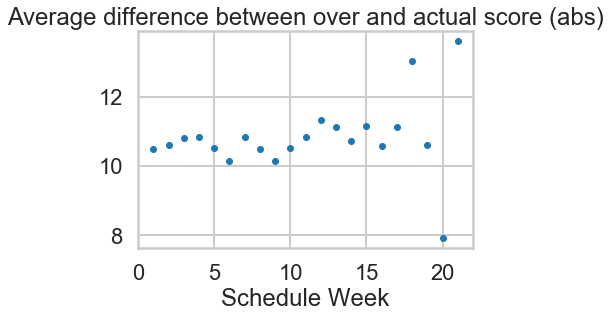

In [19]:
plt.plot( grp['over_diffabs'].mean(), linestyle='none', marker='.')
plt.title('Average difference between over and actual score (abs)')
plt.xlabel('Schedule Week')


After a further look, it appears the increased variability late in the season is due to a fewer sample size of games in that time frame. One must wonder why the lines appear to vary so little (especially the O/U) from week to week. It would be reasonable to expect as the season went on the line setters would have a better grasp of the skill level of each team and how they will match up, but that does appear to be the case. Could it be possible that the benenfit from the increase in information for the line setters as the season goes on is offset by the increased chance of unpredictible effects on games from weather. 

Text(0.5,0,'Schedule Week')

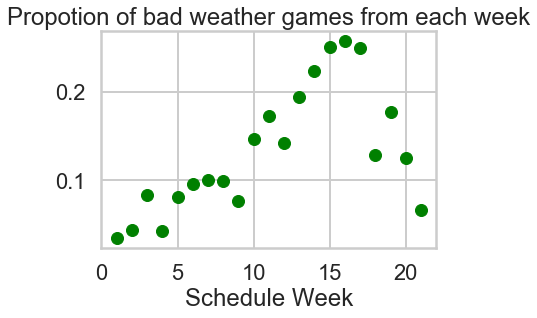

In [20]:
plt.plot( grp['bw'].sum()/grp.true.sum(), linestyle='none', marker='o', color= 'g')
plt.title('Propotion of bad weather games from each week')
plt.xlabel('Schedule Week')

As one would expect more games are played in inclimate weather as the calender turns to winter. This chart also shows we may need to control for the time of season because if one time of the season has all the bad weather, it could skew the results.

Text(0.5,0,'Schedule Week')

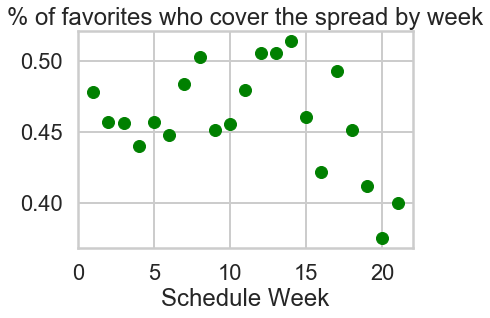

In [23]:
plt.plot( grp['favorite_cover'].sum()/grp.true.sum(), linestyle='none', marker='o', color= 'g')
plt.title('% of favorites who cover the spread by week')
plt.xlabel('Schedule Week')


In [ ]:
plt.plot( grp['over_cover'].sum()/grp.true.sum(), linestyle='none', marker='.', color= 'g')
plt.title('% of overs that cover the O/U by week')
plt.xlabel('Schedule Week')

Line setters want a favorite to cover about 50% of the time, theoretically. The real number depends on how many people bet on each team which in turn affects what number the line is set at. 50% is a good benchmark though and you can see in the favorite cover percentage by week that the percentage of covers approaches 50% for much of the first half of the season untilweek 15 which is also where we see the proportion of bad wheather games spike. From the information that has been gathered here, I think the most interesting avenue for future research is how much more disruptive is the late season weather if we control for the improvement of the line setters over the course of the season I believe we will find that the more we ae able to control for the line setter improvement the more we will see the effects of weather We will need further statistical analysis to discern wheather the weather casued this effect.

In [24]:
ppdf.to_pickle('ready_for_stats.pkl')